# EI ABM from Ombeline de Mareuil, Noé Debrois, Achraf Sbai, Théophile Rousselle, Paul Faverjon

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from  scipy import optimize
import statistics
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.stattools
import numba

## Calibration phase :

### Fixed parameters used as reference :

In [3]:
T = 10000
kappaa = 0.08
alphaa = 1/7
betaa = 0.1
gammaa = 50
sigmaa = 1
lambdaaa = 0.4

### Implementation of the model with only 5 parameters for simplicity (first) :

In [4]:
def modelMCB(kappa,beta,gamma,sigma,lambdaa):
  global alphaa
  global T
  alpha = alphaa
  p=np.zeros(T)
  v=np.zeros(T)
  v[0]=5
  m=np.zeros(T)
  epsilon = np.random.normal(0,sigma,(1,T))

  for i in range(1,T-1):
    p[i+1] = p[i] + kappa*(v[i]-p[i]) + beta*np.tanh(gamma*m[i]) + epsilon[0,i+1]
    m[i] = (1-alpha)*m[i-1] + alpha*(p[i]-p[i-1])
    v[i+1] = (1-lambdaa)*v[i] + lambdaa*p[i]

  return(p,m,v)

### Plot of the time series :

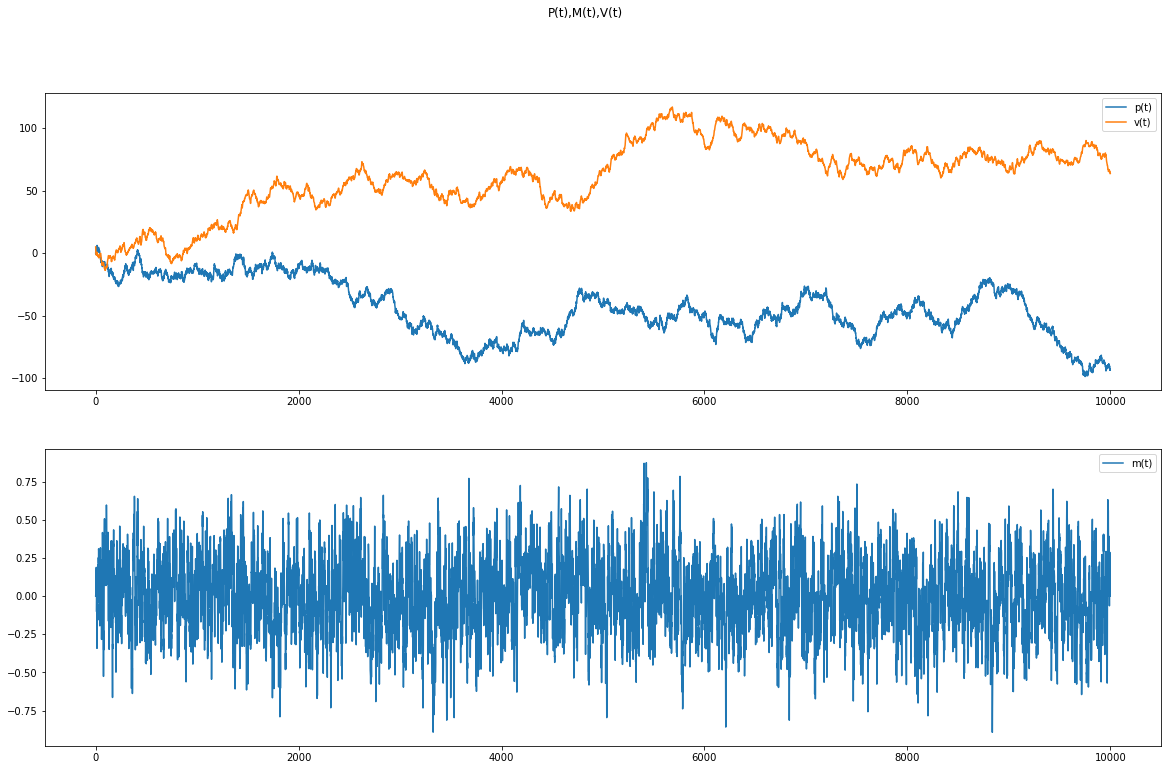

In [5]:
P=modelMCB(kappaa,betaa,gammaa,sigmaa,lambdaaa)[0]
M=modelMCB(kappaa,betaa,gammaa,sigmaa,lambdaaa)[1]
V=modelMCB(kappaa,betaa,gammaa,sigmaa,lambdaaa)[2]
plt.figure(figsize=(20,12))
plt.suptitle("P(t),M(t),V(t)")
plt.subplot(2,1,1)
plt.plot(P, label='p(t)')
plt.plot(V, label='v(t)')
plt.legend()
plt.subplot(2,1,2)
plt.plot(M, label='m(t)')
plt.legend()
plt.show()

### Computation of DW using the identity matrix :

Firstly, we compute DW with W equal to the identity matrix. It is a first approach simpler than with the iterative covariance matrix. We implemented it to use the model a few times before going further.

In [6]:
data = np.multiply(modelMCB(kappaa,betaa,gammaa,sigmaa,lambdaaa), 1e-16)[0]

''''
def DW(kappa,beta,gamma,sigma,lambdaa,K): 
    W = np.eye(K)
    res= 0 
    global data
    model = modelMCB(kappa,beta,gamma,sigma,lambdaa)
    meanmodel = np.array([np.mean(np.power(model,i)) for i in range(1,K+1)])
    meandata = np.array([np.mean(np.power(data,i)) for i in range(1,K+1)])
    res+= np.matmul(meanmodel-meandata,np.matmul(W, (meanmodel-meandata).T))
            
    return res
'''

T = 10000
alphaa = 1/7
sigmaa = 1
K=4

kappaa = 0.08
betaa = 0.1
gammaa = 50
lambdaaa = 0.4

eps = 0.5

def DW(sett): 
    kappa,beta,gamma,lambdaa = sett[0],sett[1],sett[2],sett[3]
    K=4
    W = np.eye(K)
    sigma=1
    res= 0 
    global data
    global eps
    model = modelMCB(kappa,beta,gamma,sigma,lambdaa)[0]
    meanmodel = np.array([np.mean(np.power(model,i)) for i in range(1,K+1)])
    meandata = np.array([np.mean(np.power(data,i)) for i in range(1,K+1)])
    res+= np.matmul(meanmodel-meandata,np.matmul(W, (meanmodel-meandata).T))
    return res
# DW([kappaa,betaa,gammaa,lambdaaa])

x0 =np.array([0.08,0.3,20,0.2])
opt = optimize.minimize(DW, x0, bounds =[(-0.5, 0.5),(-0.5,0.5),(1,100),(0.1,1)],options={'ftol':1e-6,'gtol':1e-6}, method="powell")
print("paramètres à trouver : (" + str(kappaa) + "," + str(betaa) + "," + str(gammaa) + "," + str(lambdaaa) + ")")
print("paramètres initiaux : " + str(x0))

/var/folders/57/_nkrw5g16dsdmygf08scq6b00000gn/T/ipykernel_95798/976927829.py:44: OptimizeWarning: Unknown solver options: gtol
  opt = optimize.minimize(DW, x0, bounds =[(-0.5, 0.5),(-0.5,0.5),(1,100),(0.1,1)],options={'ftol':1e-6,'gtol':1e-6}, method="powell")


paramètres à trouver : (0.08,0.1,50,0.4)
paramètres initiaux : [ 0.08  0.3  20.    0.2 ]


This next script runs the estimation of the parameters (again with the identity matrix) a few times and plot the time series on the graph. Even if we have estimated parameters close to the real parameters, the times series are not always super close because of the noise.

/var/folders/57/_nkrw5g16dsdmygf08scq6b00000gn/T/ipykernel_95798/2192162790.py:4: OptimizeWarning: Unknown solver options: gtol
  set_params.append(optimize.minimize(DW, x0, bounds =[(-0.5, 0.5),(-0.5,0.5),(1,100),(0.1,1)],options={'ftol':1e-6,'gtol':1e-6}, method="powell")["x"])
/var/folders/57/_nkrw5g16dsdmygf08scq6b00000gn/T/ipykernel_95798/976927829.py:37: RuntimeWarning: overflow encountered in power
  meanmodel = np.array([np.mean(np.power(model,i)) for i in range(1,K+1)])
/Users/paulfaverjon/miniforge3/envs/finance/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/var/folders/57/_nkrw5g16dsdmygf08scq6b00000gn/T/ipykernel_95798/976927829.py:39: RuntimeWarning: invalid value encountered in matmul
  res+= np.matmul(meanmodel-meandata,np.matmul(W, (meanmodel-meandata).T))


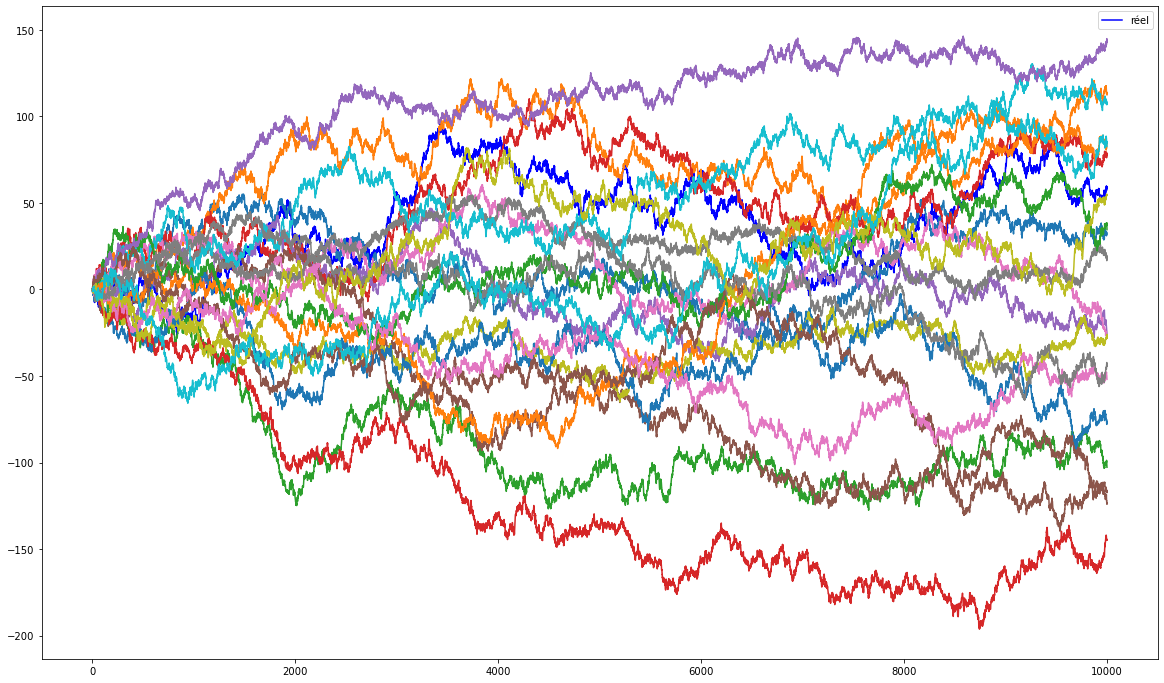

In [7]:
def script():
    set_params = []
    for k in range(20):
        set_params.append(optimize.minimize(DW, x0, bounds =[(-0.5, 0.5),(-0.5,0.5),(1,100),(0.1,1)],options={'ftol':1e-6,'gtol':1e-6}, method="powell")["x"])
    return set_params

kappaa = 0.08
betaa = 0.1
gammaa = 50
lambdaaa = 0.4

plt.figure(figsize=(20,12))
set = script()
P_reel = modelMCB(kappaa,betaa,gammaa,1,lambdaaa)[0]
plt.plot(P_reel, label="réel", c='b')
plt.legend()
for k in range(len(set)):
    plt.plot(modelMCB(set[k][0], set[k][1],set[k][2], 1, set[k][3])[0])
plt.show()

Here we compute the mean of the parameters when we estimated them a few times. We can see that we are close to the reality. However, we noticed that the function was very irregular so that sometimes we find different local minima.

In [8]:
param1 = []
param2 = []
param3 = []
param4 = []
for k in range(len(set)):
    param1.append(set[k][0])
    param2.append(set[k][1])
    param3.append(set[k][2])
    param4.append(set[k][3])
param1 = np.array(param1).mean()
param2 = np.array(param2).mean()
param3 = np.array(param3).mean()
param4 = np.array(param4).mean()
param1,param2,param3,param4

(0.1530124291363362,
 -0.045797335485315234,
 48.70983199554909,
 0.5576150063034986)

Here we plot the estimated parameters versus the real ones.

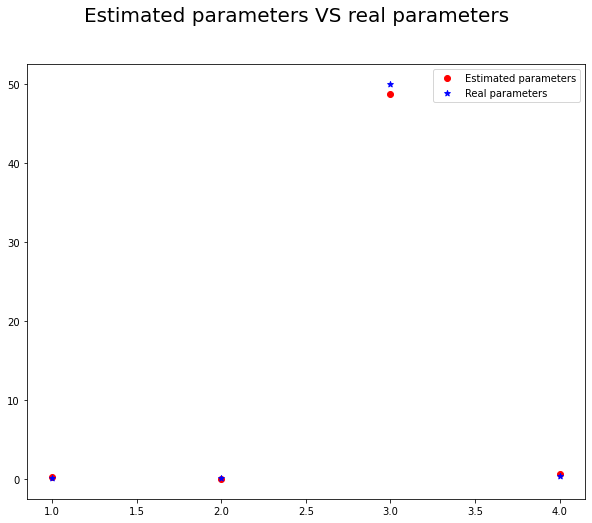

In [9]:
plt.figure(figsize=(10,8))
plt.scatter([1,2,3,4],[param1,param2,param3,param4],c='r', label='Estimated parameters',marker='o')
plt.scatter([1,2,3,4],[kappaa,betaa,gammaa,lambdaaa],c='b', label='Real parameters',marker='*')
plt.legend()
plt.suptitle('Estimated parameters VS real parameters', fontsize='20')
plt.show()

In [10]:
def error_fct(real_moments,model_moments):
    n = len(real_moments)
    e = np.zeros(n)
    for k in range(n):
        e[k] = (model_moments[k] - real_moments[k]) / real_moments[k]
    return e

In [11]:
e = error_fct([kappaa,betaa,gammaa,lambdaaa],opt["x"])
e

array([ 1.03528989,  2.04886487, -0.30362827,  0.18628667])

In [12]:
def iter_W():
    global eps
    model_P = modelMCB(kappa,beta,gamma,sigma,lambdaa)[0]

### Code with the covariance matrix :

In [13]:
# Paramètre(s) :
T = 10000
K = 4
sigma = 2
alpha = 1/7

initial_settings = [0.08, 0.1, 50, 0.4]

In [14]:
def create_noise():
    global T
    global sigma
    return np.random.normal(0,sigma,(1,T))

noise = create_noise()

In [15]:
def generate_MCB_model(settings):
    """
    Syntaxe pour settings :
    [0] : kappa
    [1] : beta
    [2] : gamma
    [3] : lambda
    """

    # global var :
    global noise
    global alpha
    global T
    
    # init :
    p=np.zeros(T)
    v=np.zeros(T)
    m=np.zeros(T)
    # v[0]=5 # initial noise on v

    # parameters :
    kappa = settings[0]
    beta = settings[1]
    gamma = settings[2]
    lambdaa = settings[3]

    for i in range(1,T-1):
        p[i+1] = p[i] + kappa*(v[i]-p[i]) + beta*np.tanh(gamma*m[i]) + noise[0,i+1]
        m[i] = (1-alpha)*m[i-1] + alpha*(p[i]-p[i-1])
        v[i+1] = (1-lambdaa)*v[i] + lambdaa*p[i]

    return(p,m,v)     

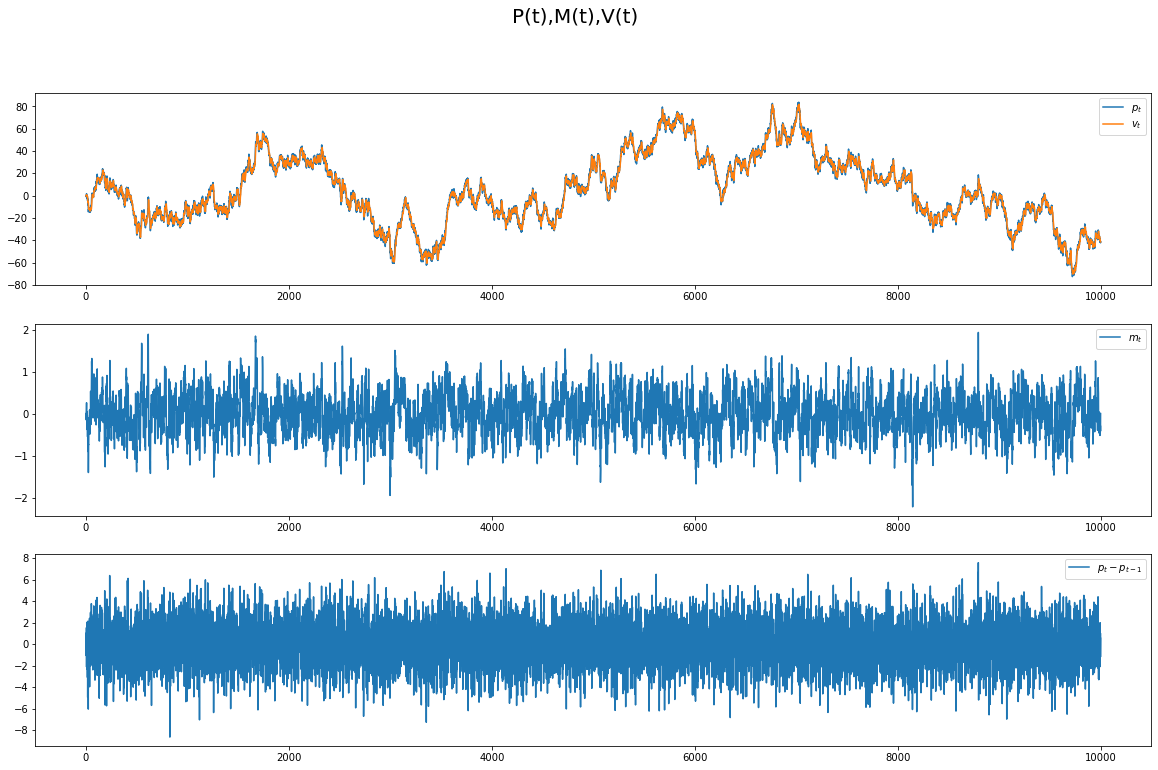

In [16]:
def plot_signals():
    global initial_settings
    P = generate_MCB_model(initial_settings)[0]
    M = generate_MCB_model(initial_settings)[1]
    V = generate_MCB_model(initial_settings)[2]
    plt.figure(figsize=(20,12))
    plt.suptitle("P(t),M(t),V(t)", fontsize='20')
    plt.subplot(3,1,1)
    plt.plot(P, label='$p_t$')
    plt.plot(V, label='$v_t$')
    plt.legend()
    plt.subplot(3,1,2)
    plt.plot(M, label='$m_t$')
    plt.legend()
    plt.subplot(3,1,3)
    plt.plot(np.diff(P), label='$p_t - p_{t-1}$')
    plt.legend()
    return plt.show()

plot_signals()

In [17]:
def modelMCB(kappa,beta,gamma,sigma,lambdaa):
  global alphaa
  alpha = alphaa
  p=np.zeros(10000)
  v=np.zeros(10000)
  m=np.zeros(10000)
  epsilon = np.random.normal(0,sigma,(1,T))

  for i in range(1,T-1):
    p[i+1]=p[i] + kappa*(v[i]-p[i])  + beta*np.tanh(gamma*m[i]) + epsilon[0,i+1]
    m[i]= (1-alpha)*m[i-1] + alpha*(p[i]-p[i-1])
    v[i+1]=(1-lambdaa)*v[i] + lambdaa*p[i]

  return(p,m,v) 

Generation of the data

In [18]:
data = np.diff(modelMCB(kappaa,betaa,gammaa,sigmaa,lambdaaa)[0])
data2= data

Here we fix epsilon = 5 to avoid too many iterations. The problem has always been the time of computation during the whole week... however, we managed to compute it with lower epsilon (<1) on google collab.

In [19]:
epsilon = 5

def DW(sett): 
        kappa,beta,gamma,lambdaa = sett[0],sett[1],sett[2],sett[3]
        global W
        global sigmaa
        global data
        global epsilon

        model = modelMCB(kappa,beta,gamma,sigmaa,lambdaa)[0]
        meanmodel = np.array([np.mean(np.power(model,1)),np.mean(np.power(model,2)), scipy.stats.kurtosis(model), statsmodels.tsa.stattools.acf(model)[1]])
        meandata = np.array([np.mean(np.power(data,1)),np.mean(np.power(data,2)), scipy.stats.kurtosis(data), statsmodels.tsa.stattools.acf(data)[1]])
        res = np.matmul(meanmodel-meandata,np.matmul(W, (meanmodel-meandata).T))
        return res

def test():
    matrix = np.zeros((20,4))
    resunew = np.array([0.05,0.3,20,0.2])
    W = np.eye(4)
    flag = 0
    compteur = 0
    while flag !=1:
        compteur+=1
        print("epoch " + str(compteur))
        if compteur > 10:
            print("Too many iterations")
            break
        for i in range(20):
            matrix[i,:]= optimize.minimize(DW,x0 =np.array([0.05,0.3,20,0.2]), bounds =[(0.08, 0.08),(-0.5,0.5),(1,100),(0.1,1)], method = "Powell")['x']
        k,b,g,l = matrix[:,0], matrix[:,1], matrix[:,2], matrix[:,3]
        W = np.cov([k,b,g,l])
        resu = resunew
        resunew = optimize.minimize(DW,x0 =np.array([0.05,0.3,20,0.2]), bounds =[(0.08, 0.08),(-0.5,0.5),(1,100),(0.1,1)], method = "Powell")['x']
        print(str(np.linalg.norm(resu-resunew)))
        if np.linalg.norm(resu-resunew)<epsilon: 
            resul1 = resunew
            flag = 1
            return [resul1[0],resul1[1],resul1[2],resul1[3]]
    return "didn't converge"
# print(test())
# k,b,g,l = resul1[0],resul1[1],resul1[2],resul1[3]

# plt.plot(modelMCB(k,b,g,sigmaa,l)[0][:1000], color = "b", label='Estimated parameters')
# plt.plot(np.cumsum(data2)[:1000], color = "r", label='Real data')
# plt.legend()
# plt.show()

In [20]:
def train(ITER):
    est_params = np.zeros((ITER,4))
    for k in range(ITER):
        val = test()
        if val=="didn't converge":
            print("This case didn't converge")
        else:
            est_params[k] = val
            plt.plot(modelMCB(est_params[k][0], est_params[k][1],est_params[k][2], 1, est_params[k][3])[0][:1000])
    plt.plot(np.cumsum(data2)[:1000], color = "r", label='Real data')
    plt.legend()
    return est_params, plt.show()

### Here we take into account the 6 parameters

In [21]:
def modelMCB6(kappa,beta,gamma,sigma,lambdaa,alpha):
    p=np.zeros(5000)
    v=np.zeros(5000)
    v[0]=5
    m=np.zeros(5000)
    epsilon = np.random.normal(0,np.abs(sigma),(1,5000))

    for i in range(1,5000-1):
        p[i+1]=p[i] + kappa*(v[i]-p[i])  + beta*np.tanh(gamma*m[i]) + epsilon[0,i+1]
        m[i]= (1-alpha)*m[i-1] + alpha*(p[i]-p[i-1])
        v[i+1]=(1-lambdaa)*v[i] + lambdaa*p[i]
    return(p,m,v) 

In [22]:
epsilon = 10

def DW(sett): 
        kappa,beta,gamma,lambdaa,sigma,alpha = sett[0],sett[1],sett[2],sett[3],sett[4],sett[5]
        global W
        global data
        global epsilon

        model = modelMCB6(kappa,beta,gamma,lambdaa,sigma,alpha)[0]
        meanmodel = np.array([np.mean(np.power(model,1)),np.mean(np.power(model,2)), scipy.stats.kurtosis(model), statsmodels.tsa.stattools.acf(model)[1]])#,statsmodels.tsa.stattools.acf(model)[2],statsmodels.tsa.stattools.acf(model)[3]])
        meandata = np.array([np.mean(np.power(data,1)),np.mean(np.power(data,2)), scipy.stats.kurtosis(data), statsmodels.tsa.stattools.acf(data)[1]])#,statsmodels.tsa.stattools.acf(data)[2],statsmodels.tsa.stattools.acf(data)[3]])
        res = np.matmul(meanmodel-meandata,np.matmul(W, (meanmodel-meandata).T))
        return res

def test():
    matrix = np.zeros((5,6))
    resunew = np.array([0.07,0.3,20,0.2,0.9,0.17])
    W = np.eye(6)
    flag = 0
    compteur = 0
    while flag !=1:
        compteur+=1
        print("epoch " + str(compteur))
        if compteur > 10:
            print("Too many iterations")
            break
        for i in range(5):
            matrix[i,:]= optimize.minimize(DW,x0 =np.array([0.07,0.3,20,0.2,0.9,1/6]), bounds =[(0.06, 0.085),(-0.5,0.5),(1,100),(0.1,1),(0.8,1),(0.125,0.2)], method = "Powell")['x']
        k,b,g,l,s,a = matrix[:,0], matrix[:,1], matrix[:,2], matrix[:,3], matrix[:,4], matrix[:,5]
        W = np.cov([k,b,g,l,s,a])
        resu = resunew
        resunew = optimize.minimize(DW,x0 =np.array([0.07,0.3,20,0.2,0.9,1/6]), bounds =[(0.06, 0.085),(-0.5,0.5),(1,100),(0.1,1),(0.8,1),(0.125,0.2)], method = "Powell")['x']
        print(str(np.linalg.norm(resu-resunew)))
        if np.linalg.norm(resu-resunew)<epsilon: 
            resul1 = resunew
            flag = 1
            return [resul1[0],resul1[1],resul1[2],resul1[3],resul1[4],resul1[5]]
    return "didn't converge"

In [23]:
def train(ITER):
    est_params = np.zeros((ITER,6))
    for k in range(ITER):
        val = test()
        if val=="didn't converge":
            print("This case didn't converge")
        else:
            est_params[k] = val
            plt.plot(modelMCB6(est_params[k][0],est_params[k][1],est_params[k][2],est_params[k][3],est_params[k][4],est_params[k][5])[0][:1000])
    plt.plot(np.cumsum(data2)[:1000], color = "r", label='Real data')
    plt.legend()
    return est_params, plt.show()

In [ ]:
res = test()

Here are the estimations :

In [ ]:
res

In [ ]:
print("paramètres réels : " + str(kappaa), str(betaa), str(gammaa), str(lambdaaa), str(sigma), str(alphaa))

paramètres réels : 0.08 0.1 50 0.4 2 0.14285714285714285


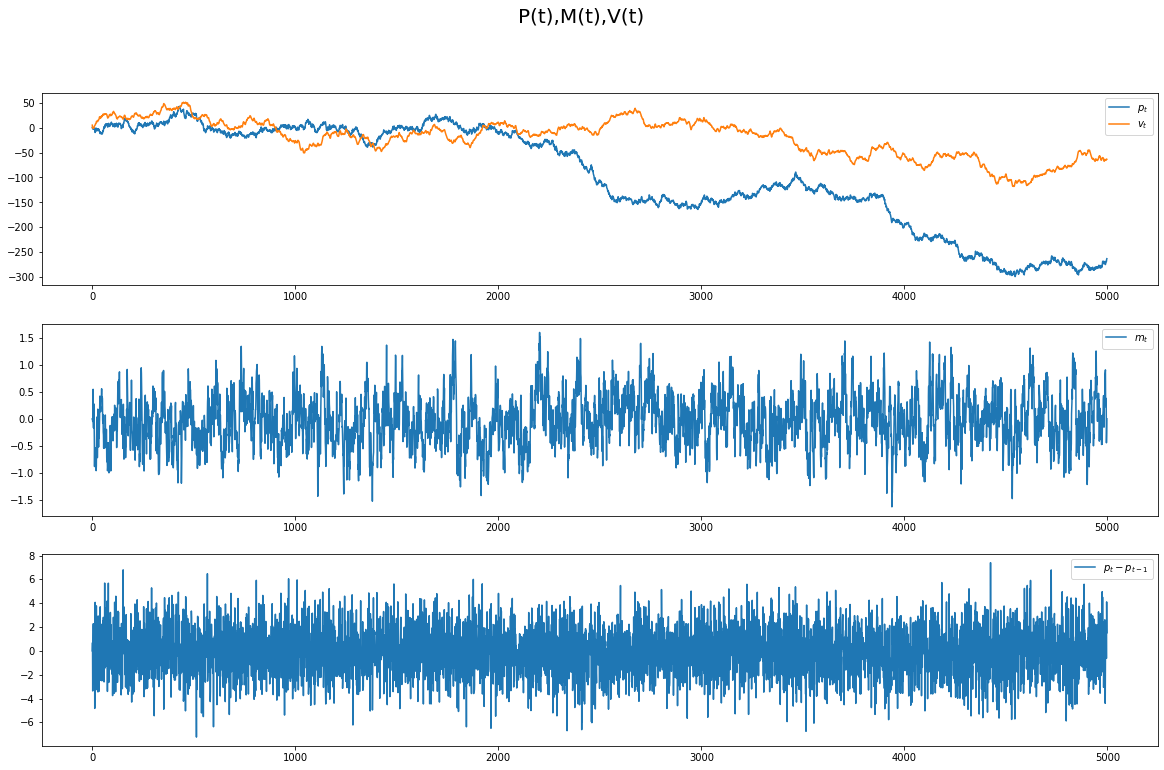

In [ ]:
def plot_signals():
    P = modelMCB6(kappaa,betaa,gammaa,sigma,lambdaaa,alphaa)[0]
    M = modelMCB6(kappaa,betaa,gammaa,sigma,lambdaaa,alphaa)[1]
    V = modelMCB6(kappaa,betaa,gammaa,sigma,lambdaaa,alphaa)[2]
    plt.figure(figsize=(20,12))
    plt.suptitle("P(t),M(t),V(t)", fontsize='20')
    plt.subplot(3,1,1)
    plt.plot(P, label='$p_t$')
    plt.plot(V, label='$v_t$')
    plt.legend()
    plt.subplot(3,1,2)
    plt.plot(M, label='$m_t$')
    plt.legend()
    plt.subplot(3,1,3)
    plt.plot(np.diff(P), label='$p_t - p_{t-1}$')
    plt.legend()
    return plt.show()

plot_signals()

## Investor behaviours

For this part, please look at the other notebook.

## Prediction 

Here we try to make some predictions. We didn't have time to finish it for two main reasons : first, we worked a lot on parts 1 and 2 so that we kind of lacked of time, and then because of the time of computation. Indeed, it was a big problem because each time we made a change in the code, we had to wait between 5 and 15 minutes for the algorithm to finish the computations.

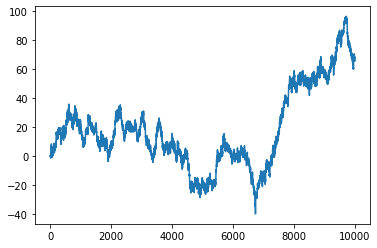

In [ ]:
Po=P
plt.plot(Po)
plt.show()

Ncalib represents the number of predictions we do. The computation time is very long but we managed to have some predictions with Ncalib = 1 or 2 after about 10 minutes of computation time. If we had more time we would have tried to parallelize the computations between our computers...

In [ ]:
Ncalib=5
param=[]         

def compute(Ncalib,serie): 
  global data
  global param
  T=int((len(serie)/2))
  data = np.array(serie[0:T])                       # if the serie come as a list
  # param = [None for i in range(Ncalib)]
  
  param.append(test())

  for t in range(1,Ncalib+1):
    P,M,V=modelMCB6(param[t-1][0],param[t-1][1],param[t-1][2],param[t-1][3],param[t-1][4],param[t-1][5])
    s = P[-1] + param[t-1][0]*(V[-1]-P[-1])  + param[t-1][1]*np.tanh(param[t-1][2]*M[-1]) + np.random.normal(0,param[t-1][3])               # calcul de $p_{t+1}$
    data = np.roll(data, -1)                                                                                                                # permutation circulaire de gauche a droite
    data[-1] = s                                                                                                                            # ajouter pt+1 a la fin de data
    param.append(test())
  return data

To=int((len(Po)/2))                                                                                                                         # effectuer une calibrartion sur la data updaté  param[t]=test()
A = compute(Ncalib,Po)


epoch 1
18.674511698659146
epoch 2


KeyboardInterrupt: 

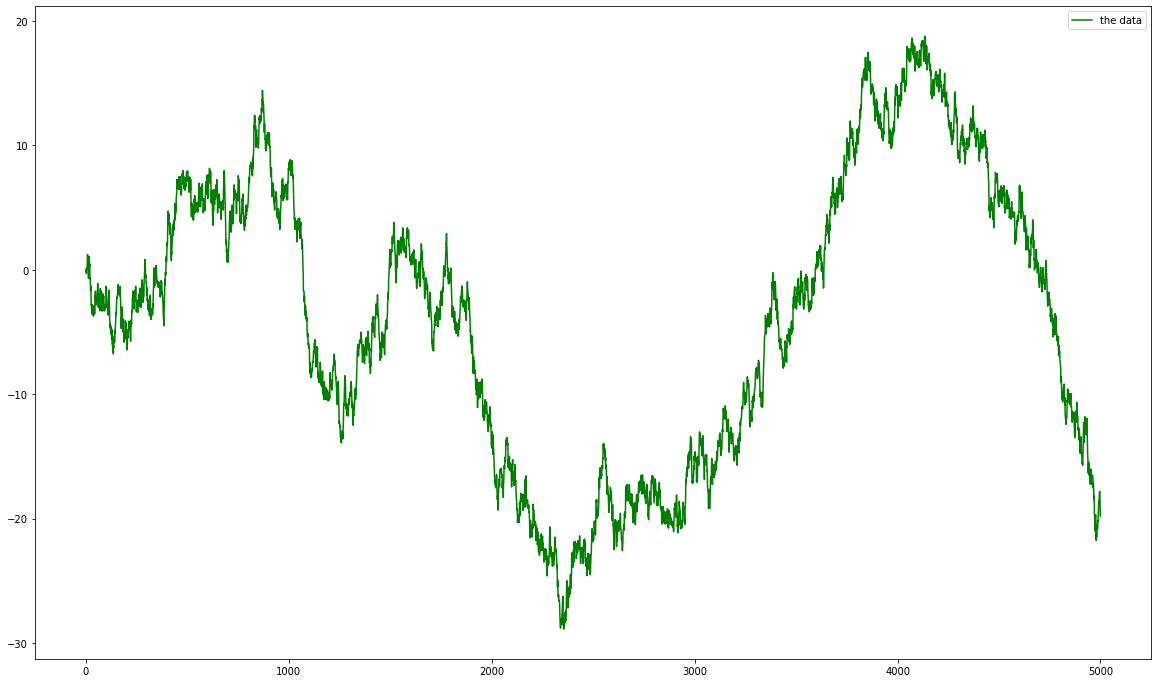

In [ ]:
plt.figure(figsize=(20,12))
plt.plot(Po[:To+Ncalib],'g',label='the data')                                                                                                                   #le tracé de T a 2T  le signal superposé avec data 
#plt.plot(A,'m',label='the prediction')
plt.legend()
plt.show()

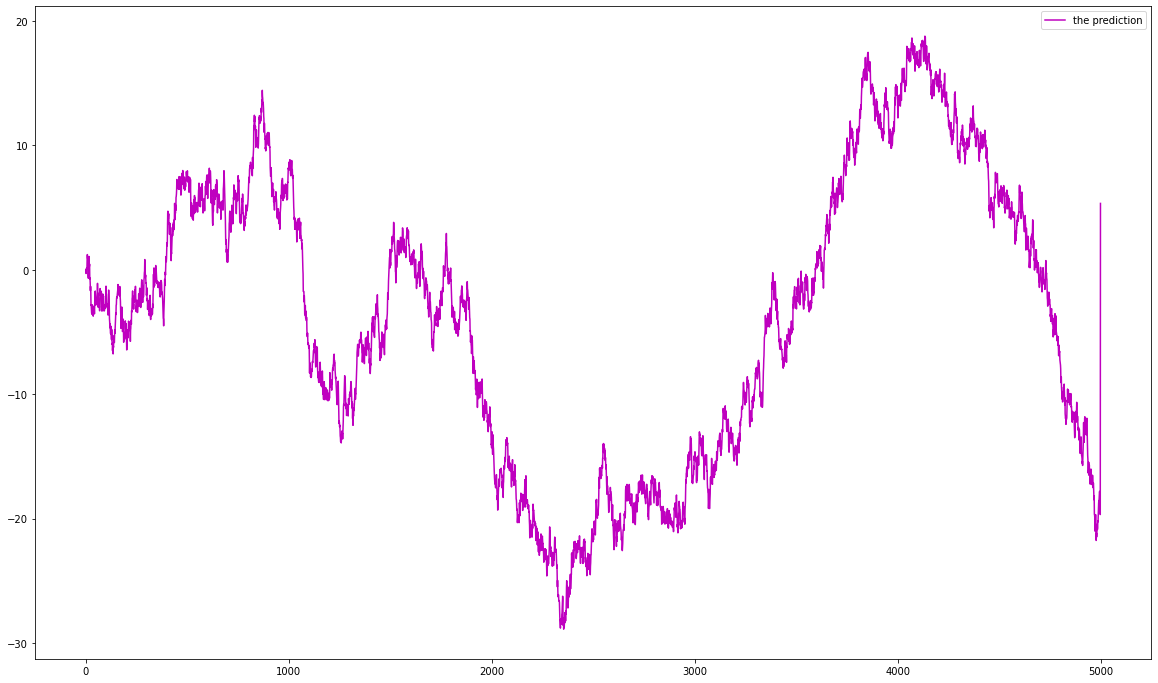

In [ ]:
plt.figure(figsize=(20,12))
plt.plot(A[:],'m',label='the prediction')
plt.legend()
plt.show()

In [ ]:
print(str(A[-3]),str(A[-2]), str(A[-1]))

-18.860825023044413 -19.66409506180792 5.334615290909448


The set of parameters we obtain :

In [ ]:
param

[[0.073810172204726,
  0.27050034179810617,
  22.173282931473288,
  0.4091664918185375,
  0.8650084021530241,
  0.16740589105640521],
 [0.06967265350525682,
  0.09682956699017986,
  22.485231895659965,
  0.7235770858886764,
  0.9568982750184281,
  0.1684970247550901]]

With more time we could run the previous algorithm with Ncalib = T, so that we would have the data between 0 and T and the predictions between T and 2T.